## Estudio Espectro de rayos X

### Requirements

In [14]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os
import gzip
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.heasarc import Heasarc
from prophet import Prophet

from astroquery.esa.xmm_newton import XMMNewton 
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits


from scipy.optimize import minimize, curve_fit
from scipy.signal import welch

# Añadir el directorio raíz del proyecto al sys.path
PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)
            

from hyper_velocity_stars_detection.astrobjects import AstroObjectProject
from hyper_velocity_stars_detection.jobs.utils import load_project, read_catalog_file
from hyper_velocity_stars_detection.tools.cluster_representations import load_isochrone_from_parsec, cmd_plot, get_best_isochrone_fitted, cmd_with_cluster, cluster_representation_with_hvs
from hyper_velocity_stars_detection.tools.cluster_detection import optimize_clustering, get_main_cluster

PATH = "../data/"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

ERROR:prophet.plot:Importing plotly failed. Interactive plots will not work.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
CLUSTER_NAME = "ngc 104"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 104 son:
Muestras seleccionadas del objeto astronómico ngc 104 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 154362.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 16353.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 16353.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 24125.

Muestras seleccionadas del objeto astronómico ngc 104 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 5444.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 1898.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 1898.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 2370.

Se han encontrado 1 fuentes de rayos X.
Estimated number of clusters: 3
Estimated number of noise points: 2269
	 - Volumen total del cluster 0: 1175.
	 - Volumen

In [46]:
project.path

'../data/'

In [4]:
project_path = os.path.join(project.path, cluster.name)
obs_id = project.xsource.results.observation_id[0]
# file_tar = f"xmm_data_{obs_id}.tar"

# XMMNewton.download_data(obs_id, extension="FTZ",filename=file_tar, cache=False)
# XMMNewton.get_epic_lightcurve(file_tar,0)
# file_tar = f"xmm_data_{obs_id}.tar"
# os.rename(file_tar, os.path.join(project_path, file_tar))

In [5]:
file_tar = os.path.join(project_path, f"xmm_data_{obs_id}.tar")
dic = XMMNewton.get_epic_lightcurve(file_tar,1)


extract_dir = os.path.join(project_path, obs_id, "pps")
list_dir = os.listdir(os.path.join(obs_id, "pps"))
os.makedirs(extract_dir, exist_ok=True)
for file in list_dir:
    os.rename(os.path.join(obs_id,"pps", file), os.path.join(extract_dir, file))

os.removedirs(os.path.join(obs_id,"pps"))
lightcurve_files = [f for f in os.listdir(extract_dir) if f.endswith('.FTZ')]
lightcurve_files

['P0679180301M1S002SRCTSR8003.FTZ',
 'P0679180301PNX000SRCTSR8001.FTZ',
 'P0679180301PNX000SRCTSR8003.FTZ',
 'P0679180301M2X000SRCTSR8003.FTZ',
 'P0679180301M2X000SRCTSR8002.FTZ',
 'P0679180301M1X000SRCTSR8001.FTZ',
 'P0679180301PNX000SRCTSR8005.FTZ',
 'P0679180301M2S003SRCTSR8001.FTZ',
 'P0679180301PNS001SRCTSR8003.FTZ',
 'P0679180301PNX000SRCTSR8004.FTZ',
 'P0679180301PNS001SRCTSR8004.FTZ',
 'P0679180301M1S002SRCTSR8001.FTZ',
 'P0679180301M2S003SRCTSR8002.FTZ',
 'P0679180301PNS001SRCTSR8002.FTZ',
 'P0679180301PNX000SRCTSR8002.FTZ',
 'P0679180301M1S002SRCTSR8002.FTZ',
 'P0679180301M2S003SRCTSR8003.FTZ',
 'P0679180301M2X000SRCTSR8001.FTZ',
 'P0679180301M1X000SRCTSR8003.FTZ',
 'P0679180301PNS001SRCTSR8005.FTZ',
 'P0679180301PNS001SRCTSR8001.FTZ',
 'P0679180301M1X000SRCTSR8002.FTZ']

In [6]:
dic = XMMNewton.get_epic_lightcurve(file_tar,1)
dic

{'M2': ['/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/notebooks/0679180301/pps/P0679180301M2X000SRCTSR8001.FTZ',
  '/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/notebooks/0679180301/pps/P0679180301M2S003SRCTSR8001.FTZ'],
 'PN': ['/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/notebooks/0679180301/pps/P0679180301PNX000SRCTSR8001.FTZ',
  '/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/notebooks/0679180301/pps/P0679180301PNS001SRCTSR8001.FTZ'],
 'M1': ['/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/notebooks/0679180301/pps/P0679180301M1X000SRCTSR8001.FTZ',
  '/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/notebooks/0679180301/pps/P0679180301M1S002SRCTSR8001.FTZ']}

../data/ngc 104/0679180301/pps/P0679180301M1S002SRCTSR8003.FTZ
(35,)


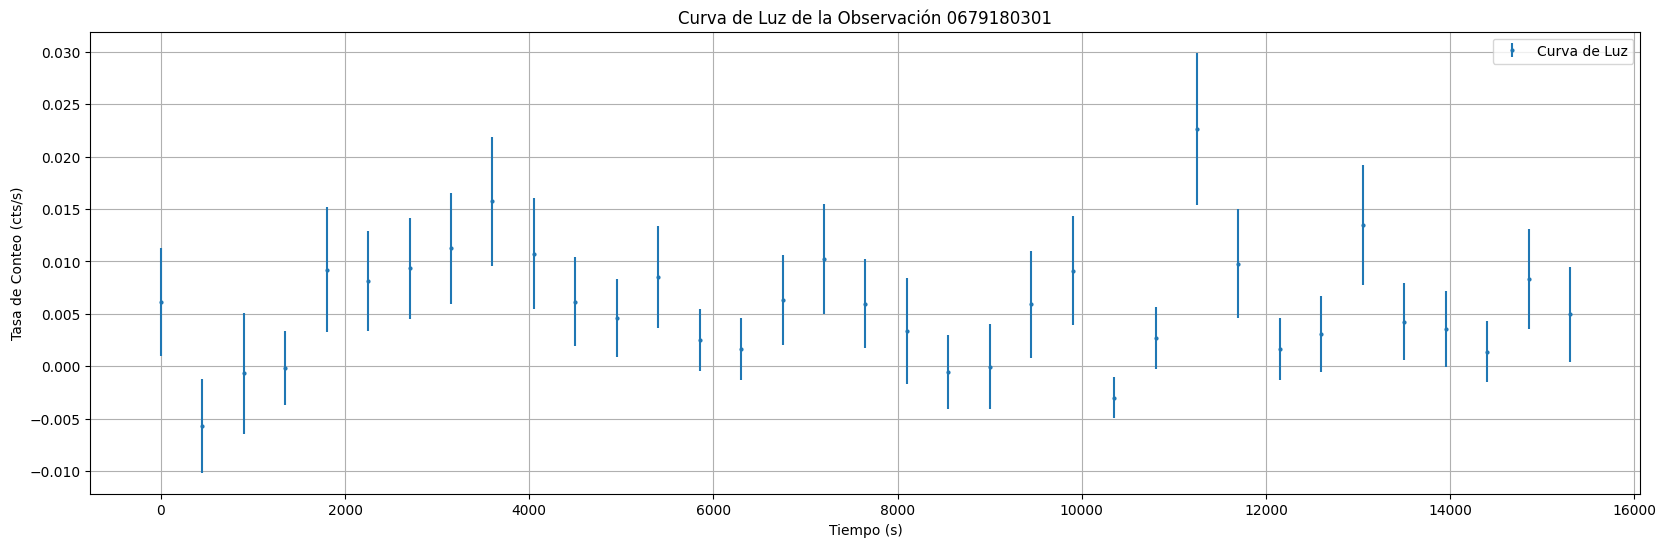

In [80]:
l_file = lightcurve_files[0]
# l_file = 'P0679180301PNX000SRCTSR8001.FTZ'
# Seleccionar el primer archivo de curva de luz encontrado
lc_ftz_file = os.path.join(extract_dir, l_file)
lc_fits_file = lc_ftz_file.replace('.FTZ', '.FITS')
print(lc_ftz_file)


# Descomprimir el archivo .FTZ a .FITS
with gzip.open(lc_ftz_file, 'rb') as f_in:
    with open(lc_fits_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Abrir el archivo FITS de la curva de luz
hdul = fits.open(lc_fits_file)
data = hdul[1].data
mask = (np.isnan(data["RATE"]) & np.isnan(data["BACKV"]) & np.isnan(data["BACKE"]) & np.isnan(data["ERROR"]))
data = np.array(data)[~mask]
print(data.shape)

# Extraer el tiempo y la tasa de conteo
time = data['TIME'] - data['TIME'].min()
rate = data['RATE'] - data['BACKV']
rate_err = np.abs(data['ERROR'] - data['BACKE'])


# Graficar la curva de luz
plt.figure(figsize=(20, 6))
#plt.plot(time, rate,  label='Curva de Luz')
plt.errorbar(time, rate, yerr=rate_err, fmt='o', markersize=2, label='Curva de Luz')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Conteo (cts/s)')
plt.title(f'Curva de Luz de la Observación {obs_id}')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
list(hdul["RATE"].data.columns)

[name = 'TIME'; format = 'D'; unit = 's',
 name = 'RATE'; format = 'E'; unit = 'count s-1',
 name = 'ERROR'; format = 'E'; unit = 'count s-1',
 name = 'FRACEXP'; format = 'E'; unit = 'fraction',
 name = 'BACKV'; format = 'E'; unit = 'count s-1',
 name = 'BACKE'; format = 'E'; unit = 'count s-1',
 name = 'RATE1'; format = 'E'; unit = 'count s-1',
 name = 'RATE1_ERR'; format = 'E'; unit = 'count s-1',
 name = 'BACK1V'; format = 'E'; unit = 'count s-1',
 name = 'BACK1E'; format = 'E'; unit = 'count s-1',
 name = 'RATE2'; format = 'E'; unit = 'count s-1',
 name = 'RATE2_ERR'; format = 'E'; unit = 'count s-1',
 name = 'BACK2V'; format = 'E'; unit = 'count s-1',
 name = 'BACK2E'; format = 'E'; unit = 'count s-1',
 name = 'RATE3'; format = 'E'; unit = 'count s-1',
 name = 'RATE3_ERR'; format = 'E'; unit = 'count s-1',
 name = 'BACK3V'; format = 'E'; unit = 'count s-1',
 name = 'BACK3E'; format = 'E'; unit = 'count s-1',
 name = 'RATE4'; format = 'E'; unit = 'count s-1',
 name = 'RATE4_ERR'; f

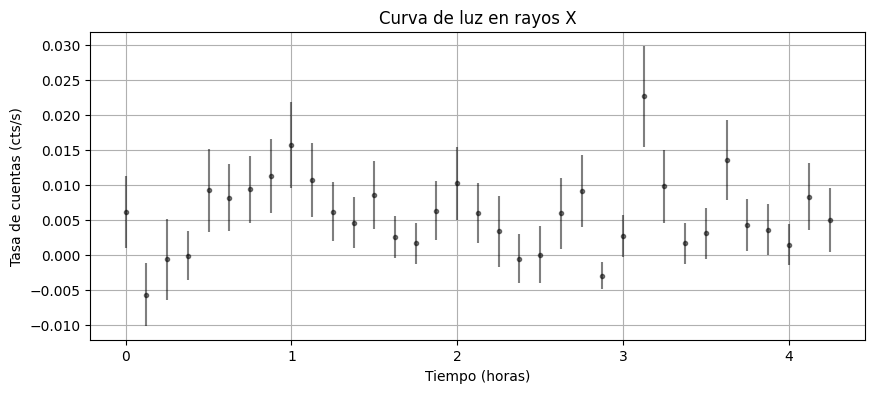

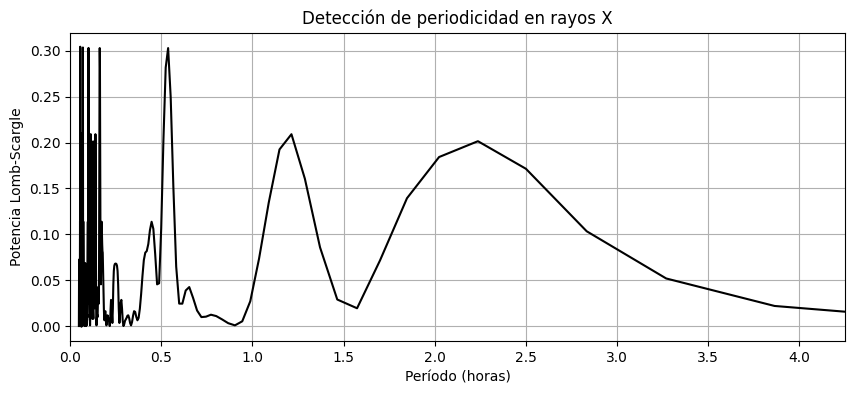

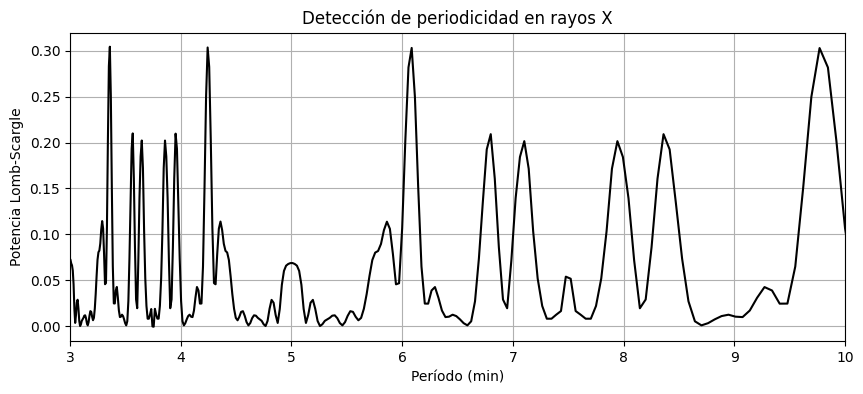

In [96]:


# Extraer el tiempo y la tasa de conteo
time = data['TIME'] - data['TIME'].min()
rate = data['RATE'] - data['BACKV']
rate_err = np.abs(data['ERROR'] - data['BACKE'])


# Aplicar la Transformada Lomb-Scargle
frequency, power = LombScargle(time, rate).autopower()

# Convertir frecuencia a período en horas
period = 1 / frequency / 3600

# Graficar la curva de luz
plt.figure(figsize=(10, 4))
plt.errorbar(time / 3600, rate, yerr=rate_err, fmt='.k', alpha=0.5)  # Convertir tiempo a horas
plt.xlabel("Tiempo (horas)")
plt.ylabel("Tasa de cuentas (cts/s)")
plt.title("Curva de luz en rayos X")
plt.grid()

# Graficar el espectro de potencia de Lomb-Scargle
plt.figure(figsize=(10, 4))
plt.plot(period, power, 'k-')
plt.xlabel("Período (horas)")
plt.ylabel("Potencia Lomb-Scargle")
plt.title("Detección de periodicidad en rayos X")
plt.xlim(0, time.max() / 3600)  # Limitar a períodos menores de 10 horas
plt.grid()

# Graficar el espectro de potencia de Lomb-Scargle
plt.figure(figsize=(10, 4))
plt.plot(period * 60, power, 'k-')
plt.xlabel("Período (min)")
plt.ylabel("Potencia Lomb-Scargle")
plt.title("Detección de periodicidad en rayos X")
plt.xlim(0.05 * 60, 10)  # Limitar a períodos menores de 10 horas
plt.grid()

plt.show()

In [90]:
time.max() / 3600

np.float64(4.25)

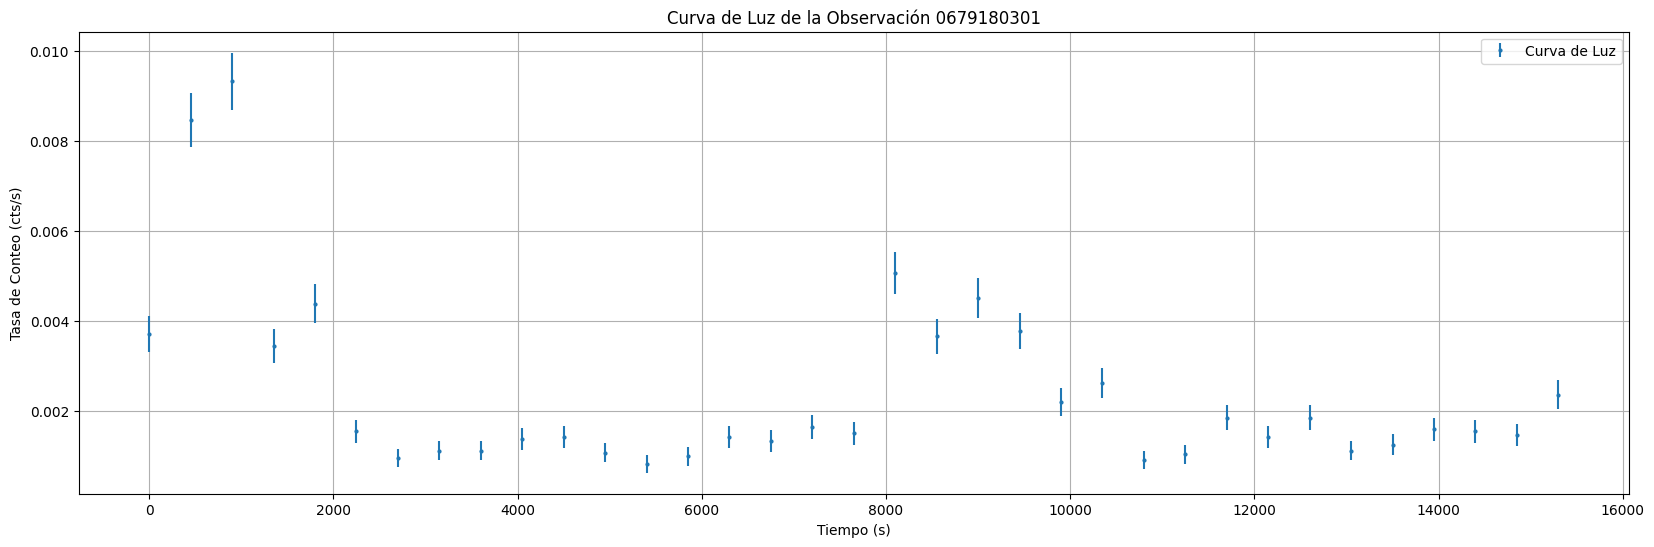

In [15]:
# Graficar la curva de luz
plt.figure(figsize=(20, 6))
# plt.scatter(time, rate,  label='Curva de Luz')
plt.errorbar(time,  data['BACKV'], yerr= data['BACKE'], fmt='o', markersize=2, label='Curva de Luz')
plt.xlabel('Tiempo (s)')
plt.ylabel('Tasa de Conteo (cts/s)')
plt.title(f'Curva de Luz de la Observación {obs_id}')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
data['RATE'].mean(), data['BACKV'].mean()

(np.float32(0.5786939), np.float32(0.033716373))

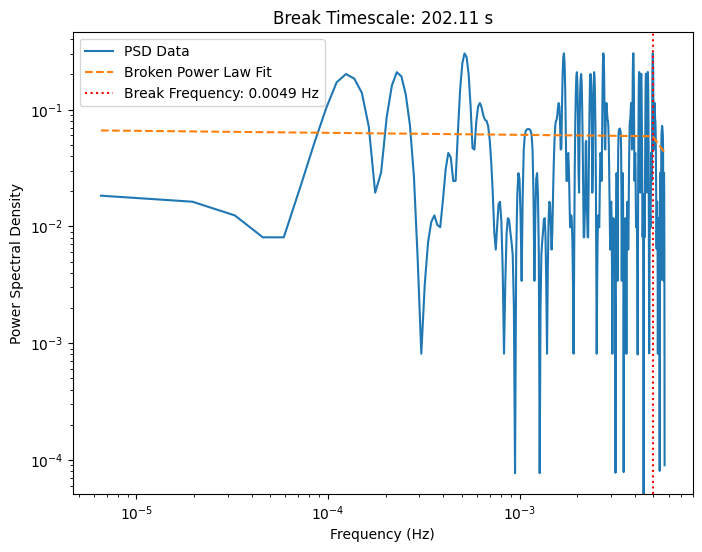

Break Timescale (T_B): 202.11 s


In [100]:

data = hdul[1].data

time = data['TIME'] - data['TIME'].min()
rate = data['RATE'] - data["BACKV"]

# Calcular la Power Spectral Density (PSD) con la función de Welch
frequencies, psd = welch(rate, fs=1/np.diff(time).mean(), nperseg=126)
# Aplicar la Transformada Lomb-Scargle
frequencies, psd = LombScargle(time, rate).autopower()


# Modelo de PSD con break
def broken_power_law(f, A, f_break, alpha_low, alpha_high):
    return A * (f/f_break)**(-alpha_low) *(f<f_break)  + A*(f/f_break)**(-alpha_high)*(f>=f_break)

# def broken_power_law(f, A, f_break, alpha_low, alpha_high):
#     return A * (f**(-alpha_low) )/ (1 + ((f / f_break)** (alpha_high - alpha_low)))

# Estimación inicial para el ajuste (A, fb, alpha1, alpha2)
p0 = [psd.mean(), frequencies[1], 1, 2]
bounds=((0, frequencies[1], 0, 0), (psd[1:].max(),  2*frequencies.max(), 2, 4))

# Ajuste del modelo al PSD
popt, pcov = curve_fit(broken_power_law, frequencies[1:], psd[1:], p0=p0, maxfev=100000, bounds=bounds)

# Extraer el break timescale (T_B = 1 / f_B)
T_B = 1 / popt[1]

# Graficar el PSD y el ajuste
plt.figure(figsize=(8,6))
plt.plot(frequencies, psd, label="PSD Data")
plt.loglog(frequencies, broken_power_law(frequencies, *popt), linestyle="--", label="Broken Power Law Fit")
plt.axvline(1/T_B, color='r', linestyle=':', label=f'Break Frequency: {1/T_B:.4f} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title(f"Break Timescale: {T_B:.2f} s")
plt.show()

print(f"Break Timescale (T_B): {T_B:.2f} s")

In [42]:
popt

array([2.16969061e+00, 1.99409747e-03, 7.95177514e-02, 4.98807263e-28])

In [144]:
hdul["SRC_GTIS"].data["STOP"]

array([4.32709447e+08], dtype='>f8')

/tmp/ipykernel_7495/3587519952.py:22: RuntimeWarning: divide by zero encountered in power
  return A * (f / fb) ** (-alpha1) * (1 + (f / fb) ** 4) ** ((alpha1 - alpha2) / 4)


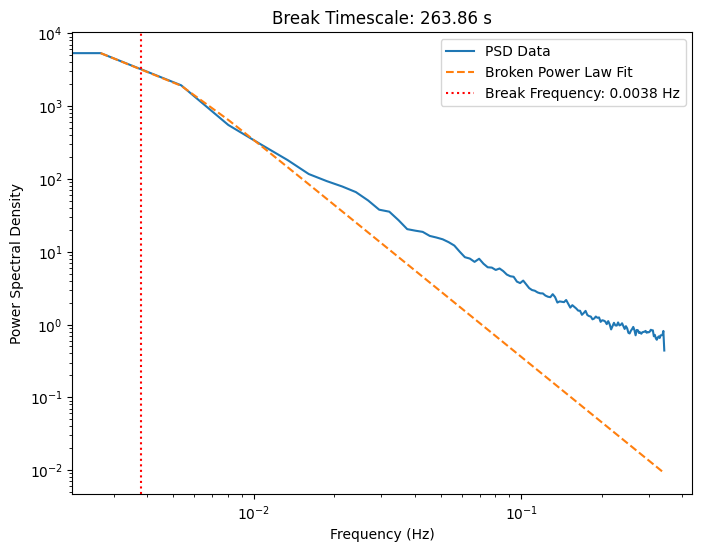

Break Timescale (T_B): 263.86 s


In [64]:
# Código de ejemplo

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.optimize import curve_fit

l_file = lfiles_candidate[1]


# Simulación de una curva de luz con ruido (en un caso real, se carga desde los datos XMM-Newton)
np.random.seed(42)
time = np.linspace(0, 50000, 5000) # 5000 puntos en 50000 segundos (~14h)
time = data["TIME"] 
flux = np.cumsum(np.random.normal(0, 1, size=len(time)))  # Señal aleatoria con tendencia

# Calcular la Power Spectral Density (PSD) con la función de Welch
frequencies, psd = welch(flux, fs=1/(time[1] - time[0]), nperseg=256)

# Función de ajuste para el PSD (Power Law con Break)
def broken_power_law(f, A, fb, alpha1, alpha2):
    return A * (f / fb) ** (-alpha1) * (1 + (f / fb) ** 4) ** ((alpha1 - alpha2) / 4)

# Estimación inicial para el ajuste (A, fb, alpha1, alpha2)
p0 = [1e3, 1e-3, 1, 2]

# Ajuste del modelo al PSD
popt, _ = curve_fit(broken_power_law, frequencies[1:], psd[1:], p0=p0, maxfev=100000, bounds=(0,np.inf))

# Extraer el break timescale (T_B = 1 / f_B)
T_B = 1 / popt[1]

# Graficar el PSD y el ajuste
plt.figure(figsize=(8,6))
plt.loglog(frequencies, psd, label="PSD Data")
plt.loglog(frequencies, broken_power_law(frequencies, *popt), linestyle="--", label="Broken Power Law Fit")
plt.axvline(popt[1], color='r', linestyle=':', label=f'Break Frequency: {popt[1]:.4f} Hz')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title(f"Break Timescale: {T_B:.2f} s")
plt.show()

print(f"Break Timescale (T_B): {T_B:.2f} s")

In [65]:
popt

array([6.30691660e+03, 3.78985305e-03, 9.60958785e-04, 2.98642588e+00])

In [99]:
frequencies, psd = welch(flux, fs=1/(time[1] - time[0]))
frequencies_r, psd_r = welch(rate, fs=1/(time[1] - time[0]))

In [100]:
(frequencies_r == frequencies).all()

np.True_

In [101]:
np.cumsum(psd_r) - psd

array([-17530.27557575, -41118.15186428, -11624.57393612,  -8755.03219034,
        -2133.89639826,  -7994.83378583,  -2306.53541585,  -1508.49548321,
        -1072.04593854,   -307.67781474,    -97.51623082,   -455.36567572,
         -162.78902305,    247.31046   ,    357.64029154,    471.66210521,
          500.3933393 ,    262.26119803,    572.72682556,    839.03950595,
          848.39221482,    767.0135454 ,    805.50597007,   1062.49372282,
         1124.87573438,   1134.97003161,   1236.86127187,   1233.68144405,
         1286.73677892,   1358.33016905,   1350.50998279,   1418.41175523,
         1474.45865531,   1617.62589935,   1694.61444772,   1749.98596135,
         1842.4590946 ,   1882.64327105,   1919.34607363,   1992.4865511 ,
         2036.87947569,   2048.54973841,   2086.94877647,   2181.79543208,
         2316.43968113,   2381.98968831,   2486.58672946,   2537.66420888,
         2606.84793785,   2730.45558026,   2831.380055  ,   2890.09953555,
         2929.88583539,  